# Business Metrics Research for Procrastinate Pro+

For several years Procrastinate Pro+ business has been constantly losing money - a lot of money was invested in attracting users, but without succes.

We need to understand the reasons for this situation in this educational dataset.

We have at our disposal a server log with data on application visits by new users who registered in the period from 2019-05-01 to 2019-10-27, uploading their purchases for this period, as well as statistics on advertising costs. We will explore how people use a product, when they start buying, how much money each customer makes, when it pays off, and what factors negatively affect user acquisition.

There is data about users attracted from May 1 to October 27, 2019:

* server log with data about their visits;
* unloading their purchases for this period;
* advertising expenses;

We will answer questions:

* where users come from and what devices they use;
* how much it costs to attract users from various advertising channels;
* how much money each client brings;
* when the cost of attracting a client pays off;
* what are the factors hindering customer acquisition;

## Loading data and preparing it for analysis

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [52]:
try:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [53]:
#quick eda function
def get_full_info(df):
    pd.set_option('display.float_format', '{:,.2f}'.format)
    display(df.head())
    print('-'*80)
    display(df.describe().T)
    print('-'*80)
    display(df.info())
    print('-'*80)

In [54]:
get_full_info(visits)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


--------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
User Id,"309,901.00","499,766,449,382.70","288,789,916,887.83","599,326.00","249,369,122,776.00","498,990,589,687.00","749,521,111,616.00","999,999,563,947.00"


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

--------------------------------------------------------------------------------


In [55]:
get_full_info(orders)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


--------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
User Id,"40,212.00","499,029,531,203.23","286,093,675,967.17","599,326.00","251,132,440,436.75","498,283,972,665.00","743,332,711,780.00","999,895,427,370.00"
Revenue,"40,212.00",5.37,3.45,4.99,4.99,4.99,4.99,49.99


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

--------------------------------------------------------------------------------


In [56]:
get_full_info(costs)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


--------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
costs,"1,800.00",58.61,107.74,0.80,6.50,12.29,33.60,630.00


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

--------------------------------------------------------------------------------


<b>Dataset desctriptions</b>

The visits_log_short table (server log with information about site visits):

    User Id - unique user identifier
    Device — user device category
    Session start - date and time of the session start
    Session End - date and time the session ends
    Channel - identifier of the advertising source from which the user came
    Region - user's country

Table orders_log_short (information about orders):

    User Id - unique id of the user who made the order
    Event Dt - date and time of purchase
    revenue - amount of money spent per purchase, euro

Table costs_short (information about marketing costs):

    Channel - advertising source identifier
    Dt - date
    Costs - the cost of this advertising source on this day, euro

In [57]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']
events = None

In [58]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])
costs['dt'] = costs['dt'].dt.date

In [59]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [60]:
print('Duplicates number for table "visits":', visits.duplicated().sum())
print('Duplicates number for table "orders":', orders.duplicated().sum())
print('Duplicates number for table "costs":', costs.duplicated().sum())

Duplicates number for table "visits": 0
Duplicates number for table "orders": 0
Duplicates number for table "costs": 0


### Conclusions

There are no serious problems with datasets in the form of gaps and duplicates, all data types are as expected, except for dates. The column names have been changed and the dates have benn casted to the datetime type

## Functions for calculating and analyzing LTV, ROI, retention and conversion

In [61]:
# add the ad_costs parameter - advertising spending
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # sort sessions by user ID and engagement date
    # group by ID and find the parameters of the first visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # the time of the first visit will be called first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # return user_id from index
    )

    # for cohort analysis, determine the date of the first visit
     # and the first day of the month in which this visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

   # add a column of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # add flags for all events from event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # check if each user is dating
            # among those who committed the event event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

  # count the number of unique users
     # with the same source and date of attraction
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        # column with the number of users will be called unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # combine spending on advertising and the number of attracted users
     # by date and acquisition channel
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

     # divide advertising costs by the number of attracted users
     # save the results in the acquisition_cost (CAC) column
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # add acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # organic users are not associated with ad data,
     # so they have NaN values in the acquisition_cost column
     # replace them with zero, because the cost of attraction is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # return profiles with Customer Acquisition Cost (CAC)

In [62]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        # build a "triangular" conversion table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # calculate the accumulated sum for each row
        result = result.fillna(0).cumsum(axis = 1)
        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # add cohort sizes to the conversion table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the size of the cohort
         # and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # exclude all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes
        result['cohort_size'] = cohort_sizes
        return result

    # receiving table with 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # remove 'cohort' from dimensions for the conversion dynamics table
    if 'cohort' in dimensions: 
        dimensions = []
    # get a table of conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [63]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
   # decide which columns to leave for retention grouping, the paying user feature column always remains
    dimensions = ['payer'] + dimensions
    
    # we cut off all users who could not "survive" to the desired horizon
     # (joined later than observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # form an array of raw data
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # function of grouping by the required set of measurements
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # build a "triangular table" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # determine cohort sizes
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # append cohort sizes to triangular table
        result = result.div(result['cohort_size'], axis = 0)                                                     # divide each of the columns by the size of the cohort - calculate the % retention (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # leave only observations up to the desired horizon and a column of cohort sizes
        result['cohort_size'] = cohort_sizes                                                                     # reassign the cohort size column, because during the division it turned into 1
        return result
    
   # calculate retention
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
   # calculate retention for all parameters + date
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # return both the hold tables and the raw data (so that in which case you can dig into them when debugging)
    return result_raw, result_grouped, result_in_time

In [64]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # add purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculate the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        # build a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # find the amount of revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combine cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculate LTV: divide each "cell" in the row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # exclude all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes
        result['cohort_size'] = cohort_sizes

        # save user data and CAC values to the dataframe,
         # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculate the average CAC by parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculate ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # remove rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restore cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # add CAC to ROI table
        roi['cac'] = cac['cac']

        # in the final table we leave the sizes of cohorts, CAC
         # and ROI in lifetimes that do not exceed the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # return LTV and ROI tables
        return result, roi

    # get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables remove 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # get tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # table LTV
        result_in_time,  # table dynamics LTV
        roi_grouped,  # table ROI
        roi_in_time,  # table dynamics ROI
    )

In [65]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [66]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
   # leave only the desired lifetime in the dynamics table
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if there is only payer in the indexes of the hold table,
     # add the second feature - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # in the graph table - two columns and two rows, four cells
     # in the first we build retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # in the second cell we build non-paying retention curves
     # vertical axis - from the graph from the first cell
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # in the third cell - the dynamics of retention of paying
    ax3 = plt.subplot(2, 2, 3)
    # get the column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter data and plot
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Engagement date')
    plt.title(
        'Dynamics of retention of paying users on day {}'.format(
            horizon
        )
    )

    # in the fourth cell - the dynamics of retention of non-paying
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter data and plot
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Engagement date')
    plt.title(
        'Dynamics of retention of non-paying users on day {}'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [67]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    #exclude cohort sizes 
    conversion = conversion.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the dynamics table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first chart - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Conversion users')

    # the second graph is the dynamics of conversion
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # all index columns except date will become pivot table columns
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Engagement date')
    plt.title('Dynamics of user conversion on day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

In [68]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    # we exclude cohort sizes from the ltv table
    ltv = ltv.drop(columns=['cohort_size'])
    # in the ltv dynamics table we leave only the necessary lifetime
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # write the cost of attraction in a separate frame
    cac_history = roi_history[['cac']]

    # from the table roi we exclude the sizes of cohorts and cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # in the roi dynamics table, we leave only the necessary lifetime
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # the second graph is the dynamics of ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Engagement date')
    plt.title('User LTV dynamics on the day {}'.format(horizon))

    # the third graph is the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Engagement date')
    plt.title('User Acquisition Cost Dynamics')

    # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # the fifth graph is the dynamics of roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # all index columns except date will become pivot table columns
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Engagement day')
    plt.title('Dynamics of ROI of users on the day {}'.format(horizon))

    plt.tight_layout()
    plt.show()


## Exploratory data analysis

### Building user profiles

In [69]:
#build user profiles
profiles = get_profiles(visits, orders, events, costs)

In [70]:
get_full_info(profiles)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


--------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
user_id,"150,008.00","499,323,784,543.79","288,948,257,508.91","599,326.00","248,924,949,195.75","497,704,624,743.00","749,491,850,048.75","999,999,563,947.00"
acquisition_cost,"150,008.00",0.70,0.95,0.00,0.00,0.25,1.11,3.72


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


None

--------------------------------------------------------------------------------


In [71]:
min_date = profiles['first_ts'].dt.date.min()
max_date = profiles['first_ts'].dt.date.max()

In [72]:
print('Earliest engagement date: {}'.format(min_date))
print('Latest engagement date: {}'.format(max_date))

Earliest engagement date: 2019-05-01
Latest engagement date: 2019-10-27


In [73]:
#Суммарное число платяших и неплатяших пользователей
profiles.groupby('payer')['payer'].count()

payer
False    141127
True       8881
Name: payer, dtype: int64

### Analysis of users' countries

In [74]:
regions = profiles.groupby('region').agg({'region': 'count'})
regions['payers'] = profiles.query('payer == True').groupby('region').agg({'payer': 'count'})
regions['region, %'] = regions['region'].apply(lambda x: round(((x/regions['region'].sum())*100), 2))
regions['payers, %'] = (regions['payers']/regions['region'])*100
display(regions)

,region,payers,"region, %","payers, %"
region,,,,
France,17450,663,11.63,3.80
Germany,14981,616,9.99,4.11
UK,17575,700,11.72,3.98
United States,100002,6902,66.66,6.90


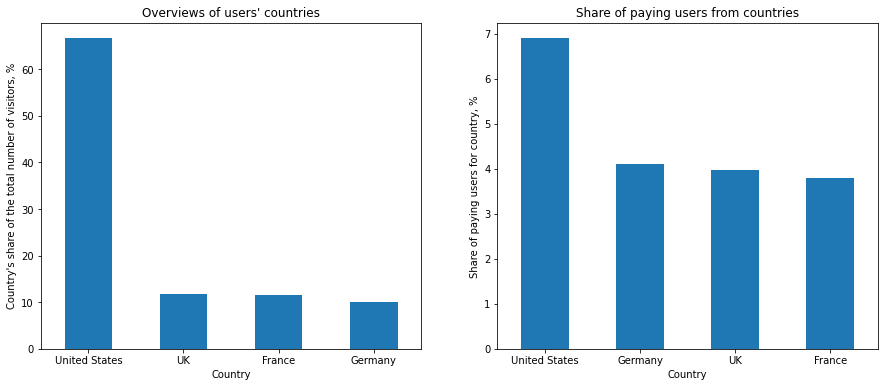

In [101]:
plt.figure(figsize=(15,6))
regions['region, %'].sort_values(ascending=False).plot(kind='bar', ax=plt.subplot(1,2,1))
plt.title("Overviews of users' countries")
plt.xlabel('Country')
plt.ylabel("Country's share of the total number of visitors, %")
plt.xticks(rotation = 0)
regions['payers, %'].sort_values(ascending=False).plot(kind='bar', ax=plt.subplot(1,2,2))
plt.title('Share of paying users from countries')
plt.ylabel('Share of paying users for country, %')
plt.xlabel('Country')
plt.xticks(rotation = 0)
plt.show()

#### Conclusions
There are a total of 150,000 users, of which 67% are from the USA, 12% each from England and France, and lasts 10% from Germany. The USA also leads in the share of buyers - 7%. The remaining countries (Germany, England and France) have an average of about 4% of the share of buyers

### Analysis of user devices

In [76]:
devices = profiles.groupby(['region', 'device']).agg({'device': 'count'})
devices['devices, %'] = devices. groupby(level=0).apply(lambda x: round(((x/x.sum())*100), 2))
devices['payers'] = profiles.query('payer == True').groupby(['region', 'device']).agg({'device': 'count'})
devices['payers, %'] = (devices['payers']/devices['device'])*100
devices

device  devices, %  payers  payers, %
region        device                                        
France        Android    5252       30.10     179       3.41
              Mac        1838       10.53      82       4.46
              PC         6940       39.77     268       3.86
              iPhone     3420       19.60     134       3.92
Germany       Android    4440       29.64     182       4.10
              Mac        1584       10.57      61       3.85
              PC         5945       39.68     253       4.26
              iPhone     3012       20.11     120       3.98
UK            Android    5141       29.25     202       3.93
              Mac        1778       10.12      63       3.54
              PC         7138       40.61     301       4.22
              iPhone     3518       20.02     134       3.81
United States Android   20199       20.20    1487       7.36
              Mac       24842       24.84    1706       6.87
              PC        10432       10.43     715       6.85
              iPhone    44529       44.53    2994       6.72

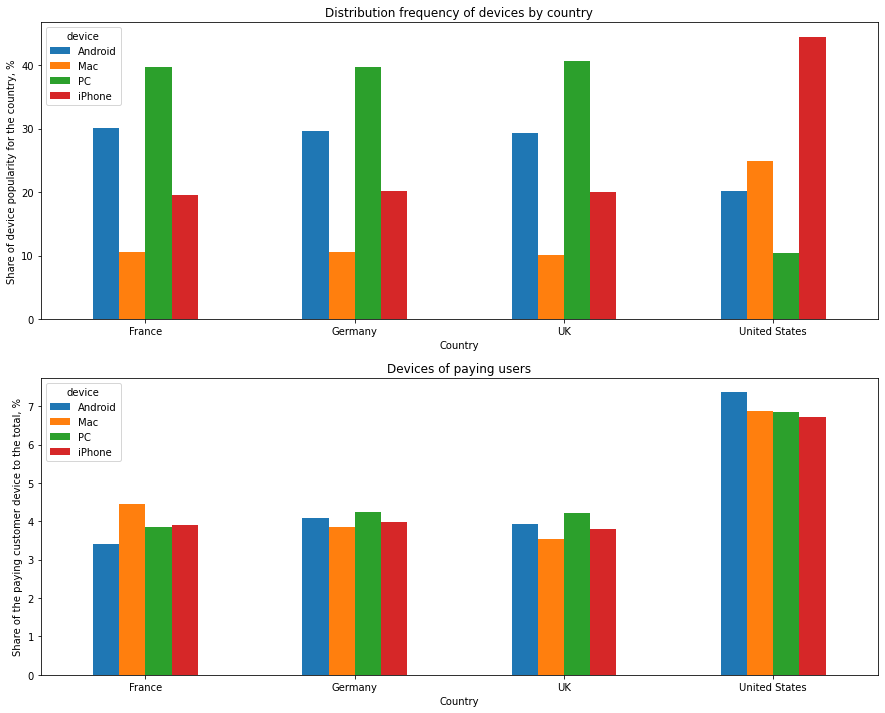

In [102]:
plt.figure(figsize=(15,12))
devices['devices, %'].unstack().plot(kind='bar', ax=plt.subplot(2, 1, 1))
plt.title('Distribution frequency of devices by country')
plt.xlabel('Country')
plt.ylabel('Share of device popularity for the country, %')
plt.xticks(rotation = 0)
devices['payers, %'].unstack().plot(kind='bar', ax=plt.subplot(2, 1, 2))
plt.title('Devices of paying users')
plt.xlabel('Country')
plt.ylabel('Share of the paying customer device to the total, %')
plt.xticks(rotation = 0)
plt.show()

#### Conclusions
For European countries (France, Germany and England) there is a similar profile of devices - Android and PC are in the lead (30% and 40% respectively), and iPhone and Mac are the last ones - 20 and 10%. In the US, the clear leader is the iPhone - 45%, then the Mac - 25%, and with a small margin Android - 20%, the remaining 10% on the PC.

For the share of paying devices, there is no obvious difference, they are all about the same level. But for European countries (France, Germany and England), the share of all paying devices is about 4%, and for the US, almost all devices are 7%, with a slight lead of Android.

### Analysis of user acquisition channels

In [78]:
channels = profiles.groupby(['channel']).agg({'user_id': 'count'})
channels['channel, %'] = round(((channels['user_id']/channels['user_id'].sum())*100), 2)
channels['payers'] = profiles.query('payer == True').groupby(['channel']).agg({'channel': 'count'})
channels['payers, %'] = (channels['payers']/channels['user_id'])*100
channels.sort_values(by = 'payers, %', ascending=False)

,user_id,"channel, %",payers,"payers, %"
channel,,,,
FaceBoom,29144,19.43,3557,12.20
AdNonSense,3880,2.59,440,11.34
lambdaMediaAds,2149,1.43,225,10.47
TipTop,19561,13.04,1878,9.60
RocketSuperAds,4448,2.97,352,7.91
WahooNetBanner,8553,5.70,453,5.30
YRabbit,4312,2.87,165,3.83
MediaTornado,4364,2.91,156,3.57
LeapBob,8553,5.70,262,3.06


In [79]:
channels_optimized = (
profiles.groupby('channel')
    .agg({'user_id':'nunique','payer':['sum','mean']})
)
channels_optimized.columns = ['channel', 'payer', 'payer, %']
channels_optimized.insert(1,'channel, %', (channels_optimized['channel']/channels_optimized['channel'].sum()))
(
channels_optimized.sort_values(by=('payer, %'),ascending=False)
    .style.format({'channel, %':'{:.2%}', 'payer, %':'{:.2%}'})
)

,channel,"channel, %",payer,"payer, %"
channel,,,,
FaceBoom,29144,19.43%,3557,12.20%
AdNonSense,3880,2.59%,440,11.34%
lambdaMediaAds,2149,1.43%,225,10.47%
TipTop,19561,13.04%,1878,9.60%
RocketSuperAds,4448,2.97%,352,7.91%
WahooNetBanner,8553,5.70%,453,5.30%
YRabbit,4312,2.87%,165,3.83%
MediaTornado,4364,2.91%,156,3.57%
LeapBob,8553,5.70%,262,3.06%


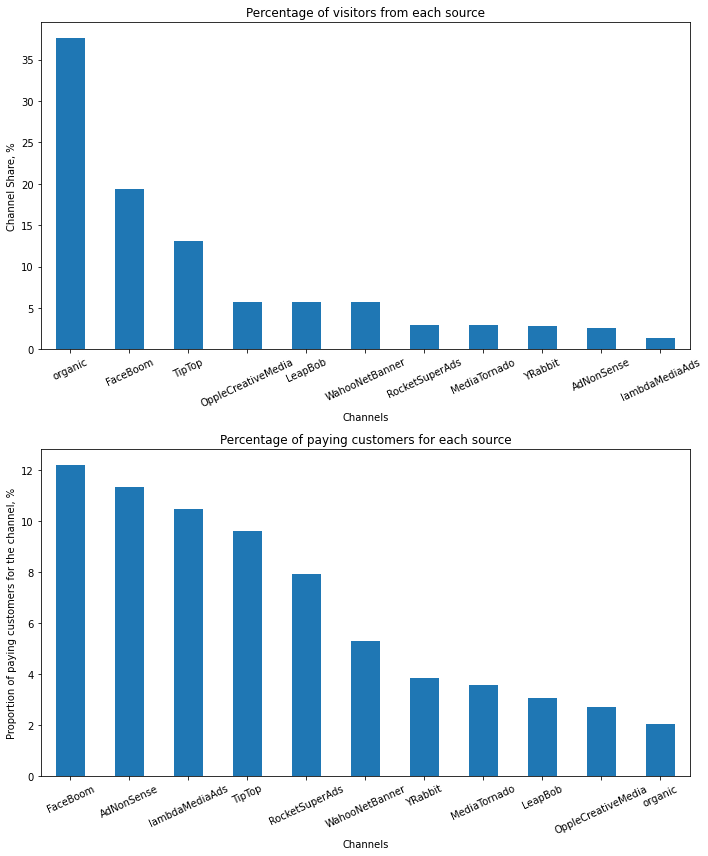

In [105]:
plt.figure(figsize=(10,12))
channels['channel, %'].sort_values(ascending=False).plot(kind='bar', ax=plt.subplot(2, 1, 1))
plt.title('Percentage of visitors from each source')
plt.xlabel('Channels')
plt.ylabel('Channel Share, %')
plt.xticks(rotation = 25)
channels['payers, %'].sort_values(ascending=False).plot(kind='bar', ax=plt.subplot(2, 1, 2))
plt.title('Percentage of paying customers for each source')
plt.xlabel('Channels')
plt.ylabel('Proportion of paying customers for the channel, %')
plt.xticks(rotation = 25)
plt.tight_layout()
plt.show()

#### Conclusions
We see that the largest flow is organic - over 35%. Next come the top 2 leaders - Faceboom and TipTop (20% and 13%). Other media do not exceed 6%.

The situation with paying customers is more interesting. Faceboom is also the leader here (12%), but the next 4 agencies are not far behind - 11% AdNonSense, 10% - lambdaMediaAds, 10% - TipTop, 8% - RocketSuperAds. Further, the interest drops sharply to 6-3% per agency. Organic clients are predictably in last place.

## Marketing cost analysis

In [81]:
total_costs = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
total_costs = total_costs.merge(channels, on='channel', how='left')
total_costs = total_costs.drop(columns = ['channel, %', 'payers, %'])
#total_costs['CAC'] = total_costs['costs'] / total_costs['user_id']
total_costs['CAC'] = profiles.groupby('channel').agg({'acquisition_cost':'mean'})
total_costs['cost_per_paying_user'] = total_costs['costs'] / total_costs['payers']
total_costs.sort_values(by='CAC', ascending=False)

,costs,user_id,payers,CAC,cost_per_paying_user
channel,,,,,
TipTop,"54,751.30",19561,1878,2.80,29.15
FaceBoom,"32,445.60",29144,3557,1.11,9.12
AdNonSense,"3,911.25",3880,440,1.01,8.89
lambdaMediaAds,"1,557.60",2149,225,0.72,6.92
WahooNetBanner,"5,151.00",8553,453,0.60,11.37
RocketSuperAds,"1,833.00",4448,352,0.41,5.21
OppleCreativeMedia,"2,151.25",8605,233,0.25,9.23
YRabbit,944.22,4312,165,0.22,5.72
MediaTornado,954.48,4364,156,0.22,6.12


In [82]:
costs_per_date = costs.groupby('dt').agg({'costs': 'sum'})
costs_per_date.reset_index(drop=False, inplace=True)
costs_per_date['month'] = pd.to_datetime(costs_per_date['dt']).dt.month
costs_per_month = costs_per_date.groupby('month').agg({'costs': 'sum'})

In [83]:
cost_per_date_channel = costs.groupby(['dt', 'channel']).agg({'costs': 'sum'})

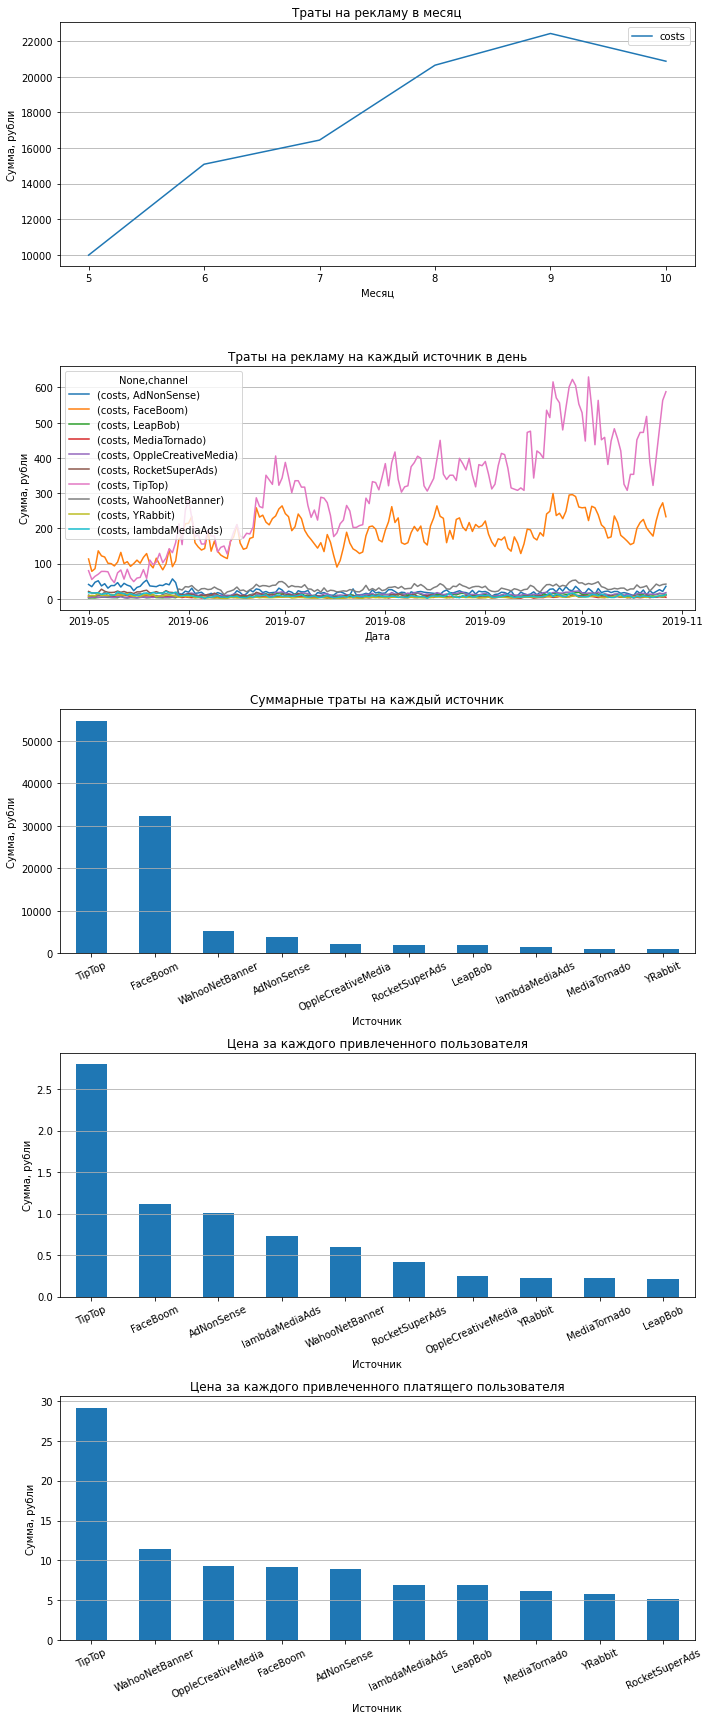

In [84]:
plt.figure(figsize=(10, 24))
costs_per_month.plot(kind='line', ax = plt.subplot(5, 1, 1)).grid(axis='y')
plt.title('Траты на рекламу в месяц')
plt.xlabel('Месяц')
plt.ylabel('Сумма, рубли')
plt.xticks(rotation = 0)
cost_per_date_channel.unstack().plot(kind='line', ax = plt.subplot(5, 1, 2)).grid(axis='y')
plt.title('Траты на рекламу на каждый источник в день')
plt.xlabel('Дата')
plt.ylabel('Сумма, рубли')
plt.xticks(rotation = 0)
total_costs['costs'].sort_values(ascending=False).plot(kind='bar', ax = plt.subplot(5, 1, 3)).grid(axis='y')
plt.title('Суммарные траты на каждый источник')
plt.xlabel('Источник')
plt.ylabel('Сумма, рубли')
plt.xticks(rotation = 25)
total_costs['CAC'].sort_values(ascending=False).plot(kind='bar', ax = plt.subplot(5, 1, 4)).grid(axis='y')
plt.title('Цена за каждого привлеченного пользователя')
plt.xlabel('Источник')
plt.ylabel('Сумма, рубли')
plt.xticks(rotation = 25)
total_costs['cost_per_paying_user'].sort_values(ascending=False).plot(kind='bar', ax = plt.subplot(5, 1, 5)).grid(axis='y')
plt.title('Цена за каждого привлеченного платящего пользователя')
plt.xlabel('Источник')
plt.ylabel('Сумма, рубли')
plt.xticks(rotation = 25)
plt.tight_layout()
plt.show()

### Conclusions

The total spending on marketing from May to November 2019 amounted to 105,497 euro. More than 80% of the budget went to only two companies - TipTop and Faceboom (55,000 and 33,000 euro, respectively). We also see that 10,000 was spent on marketing in May with a gradual increase to 20,000 per month. And all that growth has come from TipTop and Faceboom. Budgets for other firms did not change significantly, except for AdNonSence, which fell sharply after May.

We also see that the CAC for TipTop stands out from the rest and is 2.8 euro per client. Next come FaceBoom and AdNonSence with a price of 1 euro per client, all other firms have a price of less than 1 euro.

## Estimating the ROI of advertising to attract users

### Total return on advertising

In [85]:
#Let's set the observation date 2019-11-01 and the horizon of 14 days
observation_date = datetime(2019, 11, 1).date()
horizon = 14
profiles = profiles.query('channel != "organic"')

In [106]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon
)

# tables LTV and ROI
display(ltv)
display(roi)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.35,0.44,0.50,0.56,0.61,0.65,0.69,0.73,0.76,0.80,0.83,0.85,0.88,0.90


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,,
All users,88644,1.12,0.31,0.39,0.45,0.50,0.55,0.59,0.62,0.65,0.68,0.71,0.74,0.76,0.79,0.81


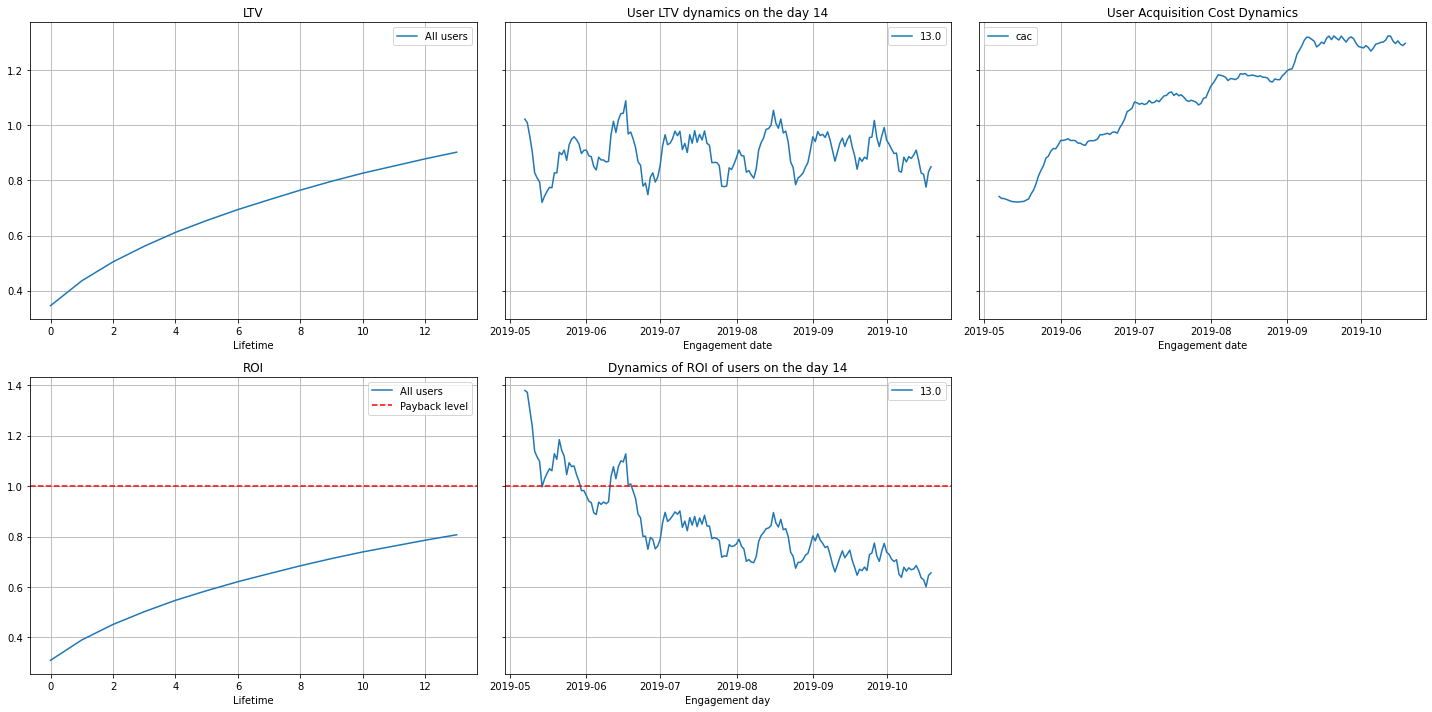

In [87]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

#### Conclusions
We see that in general advertising does not pay off for most of June, July, August, September and October with a noticeable trend towards a decrease in payback. Only May paid off with a noticeable drop in June.

There is also a strong increase in the dynamics of the cost of user acquisition (with a constant drop in ROI), which almost doubled from May to November with the largest jump in June and then a gradual increase.


### Ad ROI analysis by device

In [107]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions = ['device']
)

# table LTV
display(ltv)
display(roi)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,
Android,20683,0.34,0.43,0.50,0.56,0.61,0.66,0.70,0.74,0.77,0.81,0.83,0.86,0.89,0.91
Mac,17747,0.38,0.48,0.55,0.61,0.65,0.69,0.72,0.75,0.79,0.83,0.86,0.88,0.90,0.93
PC,18128,0.28,0.36,0.43,0.49,0.54,0.58,0.63,0.66,0.70,0.73,0.76,0.79,0.81,0.84
iPhone,32086,0.37,0.46,0.52,0.58,0.63,0.67,0.71,0.75,0.78,0.81,0.84,0.87,0.89,0.92


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,,
Android,20683,1.02,0.33,0.42,0.49,0.54,0.60,0.65,0.69,0.72,0.76,0.79,0.82,0.84,0.87,0.89
Mac,17747,1.28,0.30,0.38,0.43,0.47,0.51,0.54,0.57,0.59,0.62,0.65,0.67,0.69,0.71,0.73
PC,18128,0.79,0.35,0.46,0.54,0.61,0.68,0.73,0.80,0.84,0.88,0.92,0.96,0.99,1.02,1.05
iPhone,32086,1.28,0.29,0.36,0.41,0.46,0.50,0.53,0.56,0.59,0.61,0.64,0.66,0.68,0.70,0.72


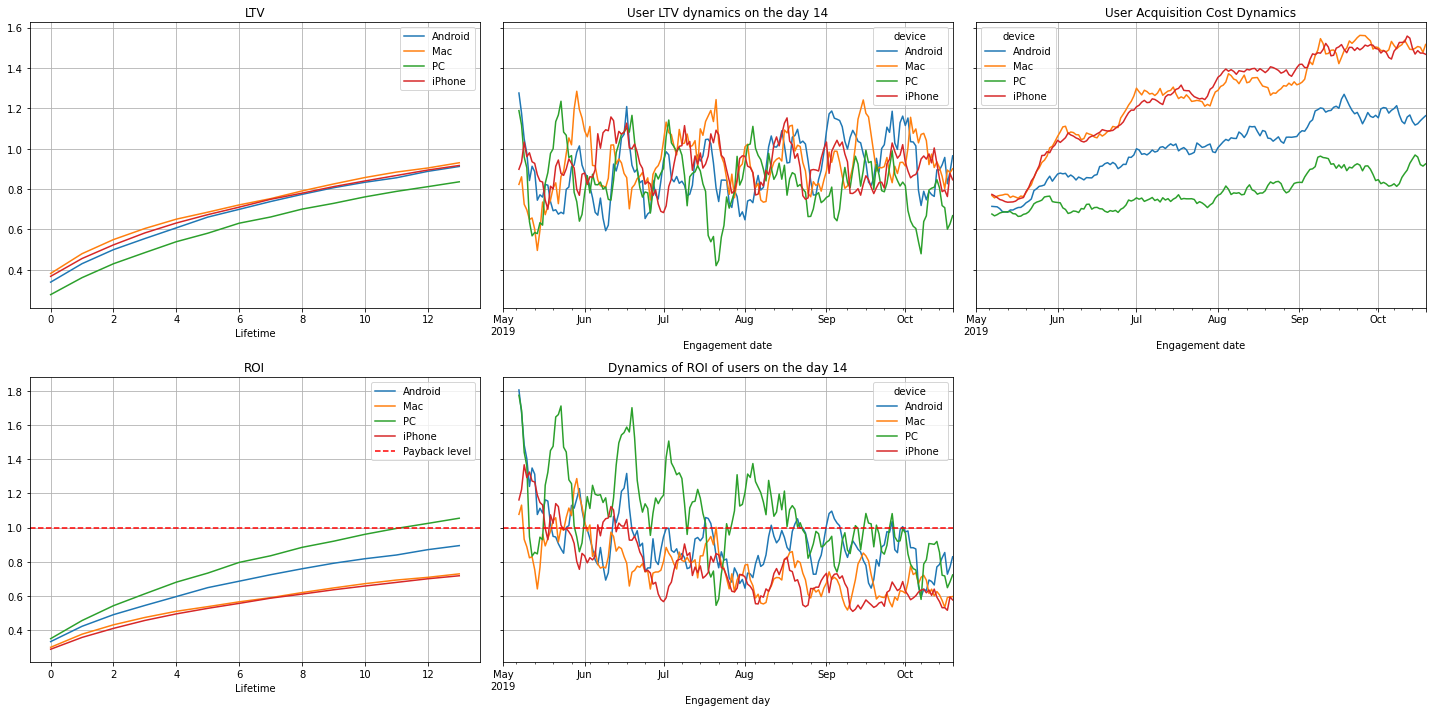

In [89]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

#### Conclusions
We can see that LTV is almost the same across all devices, with PC slightly behind. Also, the dynamics of the cost of user acquisition coincides with the overall dynamics of the cost, but the strongest growth for Mac and iPhone.

It is interesting to note that the RS pays off, albeit with a minimal payback. RS pays off only on the 12-13th day. The dynamics of ROI is falling for everyone, even for PCs, and at this rate, even PCs will soon cease to pay off (there was no payback in October).

### Analysis of marketing ROI by country

In [108]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions = ['region']
)

# table LTV
display(ltv)
display(roi)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,10516,0.19,0.26,0.31,0.36,0.41,0.45,0.48,0.51,0.54,0.57,0.60,0.62,0.65,0.67
Germany,9030,0.19,0.26,0.33,0.38,0.42,0.46,0.50,0.53,0.57,0.61,0.64,0.67,0.69,0.71
UK,10536,0.22,0.30,0.37,0.42,0.47,0.50,0.56,0.59,0.62,0.65,0.67,0.69,0.72,0.74
United States,58562,0.42,0.52,0.59,0.65,0.70,0.75,0.79,0.83,0.86,0.89,0.92,0.95,0.98,1.00


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,,
France,10516,0.46,0.42,0.56,0.68,0.78,0.88,0.98,1.05,1.10,1.18,1.24,1.30,1.35,1.41,1.46
Germany,9030,0.46,0.40,0.56,0.71,0.81,0.91,0.99,1.07,1.15,1.23,1.30,1.38,1.43,1.49,1.53
UK,10536,0.45,0.48,0.65,0.81,0.92,1.02,1.11,1.22,1.29,1.37,1.42,1.47,1.52,1.58,1.63
United States,58562,1.46,0.29,0.36,0.41,0.45,0.48,0.51,0.54,0.57,0.59,0.61,0.63,0.65,0.67,0.69


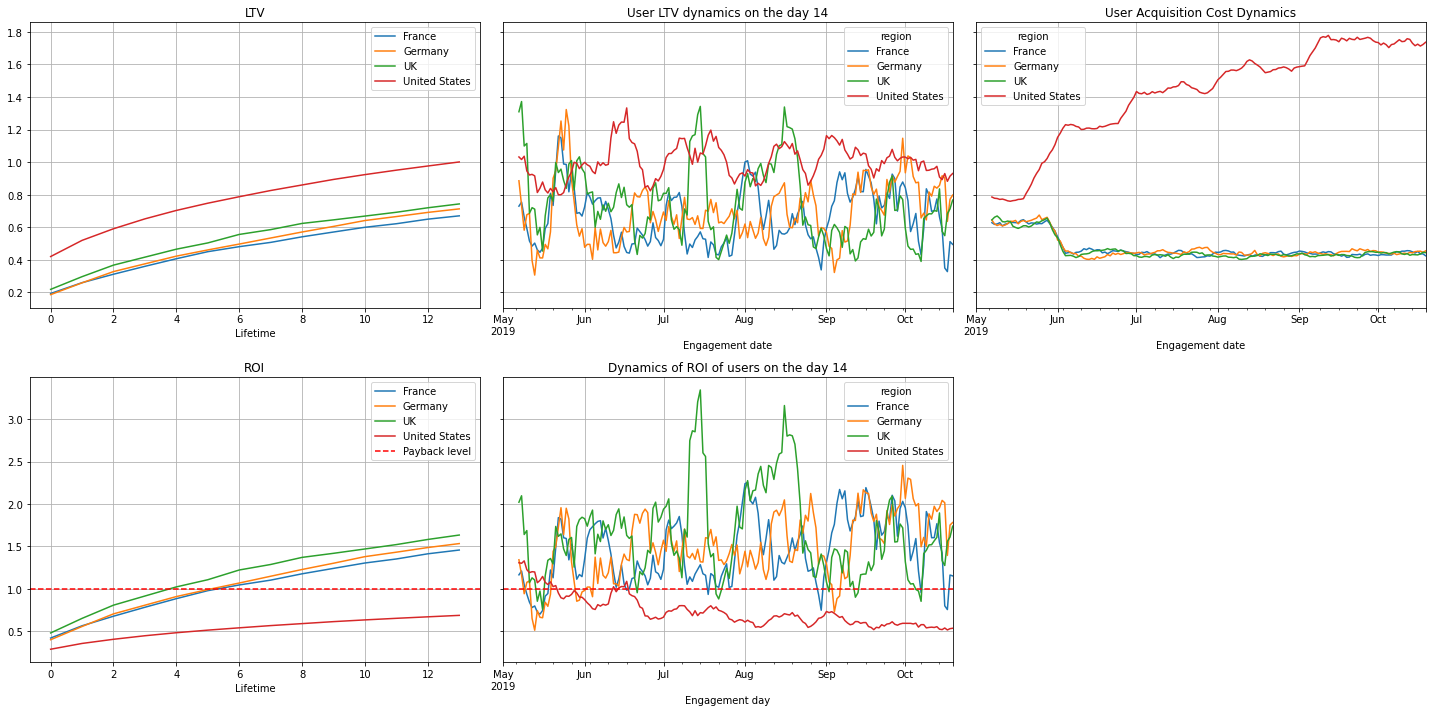

In [91]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

#### Сonclusions

Here appears the first serious clue to the causes of losses. Although we see that LTV for the USA is 1, instead of 0.6-0.7 for the other three countries. We see that almost all of the increased advertising budget goes to the US with a constant increase in the cost of user acquisition. For France, Germany and England, surprisingly on the contrary, the cost of attraction fell after June and remained at the same low level throughout the period.

The graph with ROI is also very important, we see that Germany, France and England already pay off on the 6th day, and their ROI steadily pays off for the entire period, then the USA does not even pay off on the 14th day, and the dynamics shows that a small payback was only in May, with a steady decline in the following months.

### Analyis of ROI by advertising channel

In [92]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions = ['channel']
)

display(ltv)
display(roi)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.51,0.59,0.64,0.68,0.71,0.73,0.75,0.77,0.79,0.80,0.81,0.82,0.83,0.84
FaceBoom,27544,0.59,0.66,0.70,0.73,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.81,0.82,0.82
LeapBob,8103,0.11,0.16,0.21,0.24,0.26,0.29,0.31,0.33,0.37,0.39,0.42,0.44,0.46,0.47
MediaTornado,4167,0.14,0.19,0.25,0.29,0.33,0.37,0.39,0.42,0.44,0.46,0.49,0.51,0.53,0.53
OppleCreativeMedia,8139,0.10,0.13,0.17,0.21,0.24,0.27,0.29,0.31,0.33,0.35,0.36,0.38,0.40,0.41
RocketSuperAds,4251,0.21,0.32,0.40,0.46,0.52,0.57,0.64,0.69,0.74,0.79,0.83,0.86,0.90,0.93
TipTop,18498,0.34,0.50,0.62,0.74,0.84,0.94,1.01,1.10,1.17,1.25,1.31,1.37,1.43,1.49
WahooNetBanner,8082,0.19,0.29,0.38,0.44,0.52,0.57,0.63,0.68,0.73,0.77,0.81,0.85,0.89,0.92
YRabbit,4102,0.16,0.21,0.26,0.30,0.36,0.39,0.41,0.44,0.46,0.48,0.50,0.52,0.55,0.56


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
AdNonSense,3702,1.01,0.50,0.58,0.64,0.68,0.70,0.73,0.75,0.76,0.78,0.80,0.80,0.81,0.82,0.83
FaceBoom,27544,1.11,0.53,0.59,0.63,0.65,0.67,0.68,0.70,0.70,0.71,0.72,0.72,0.73,0.73,0.74
LeapBob,8103,0.21,0.51,0.74,0.98,1.12,1.24,1.37,1.50,1.59,1.76,1.88,1.99,2.09,2.18,2.25
MediaTornado,4167,0.22,0.63,0.87,1.13,1.34,1.52,1.68,1.77,1.91,2.01,2.11,2.22,2.32,2.40,2.44
OppleCreativeMedia,8139,0.25,0.39,0.53,0.69,0.83,0.96,1.07,1.16,1.24,1.31,1.39,1.46,1.51,1.58,1.64
RocketSuperAds,4251,0.42,0.50,0.76,0.95,1.09,1.24,1.37,1.53,1.65,1.77,1.89,1.99,2.07,2.15,2.24
TipTop,18498,2.76,0.12,0.18,0.23,0.27,0.31,0.34,0.37,0.40,0.42,0.45,0.48,0.50,0.52,0.54
WahooNetBanner,8082,0.60,0.32,0.48,0.63,0.74,0.86,0.95,1.05,1.13,1.21,1.27,1.35,1.41,1.48,1.53
YRabbit,4102,0.22,0.75,0.98,1.18,1.40,1.64,1.79,1.91,2.02,2.12,2.21,2.31,2.41,2.52,2.58


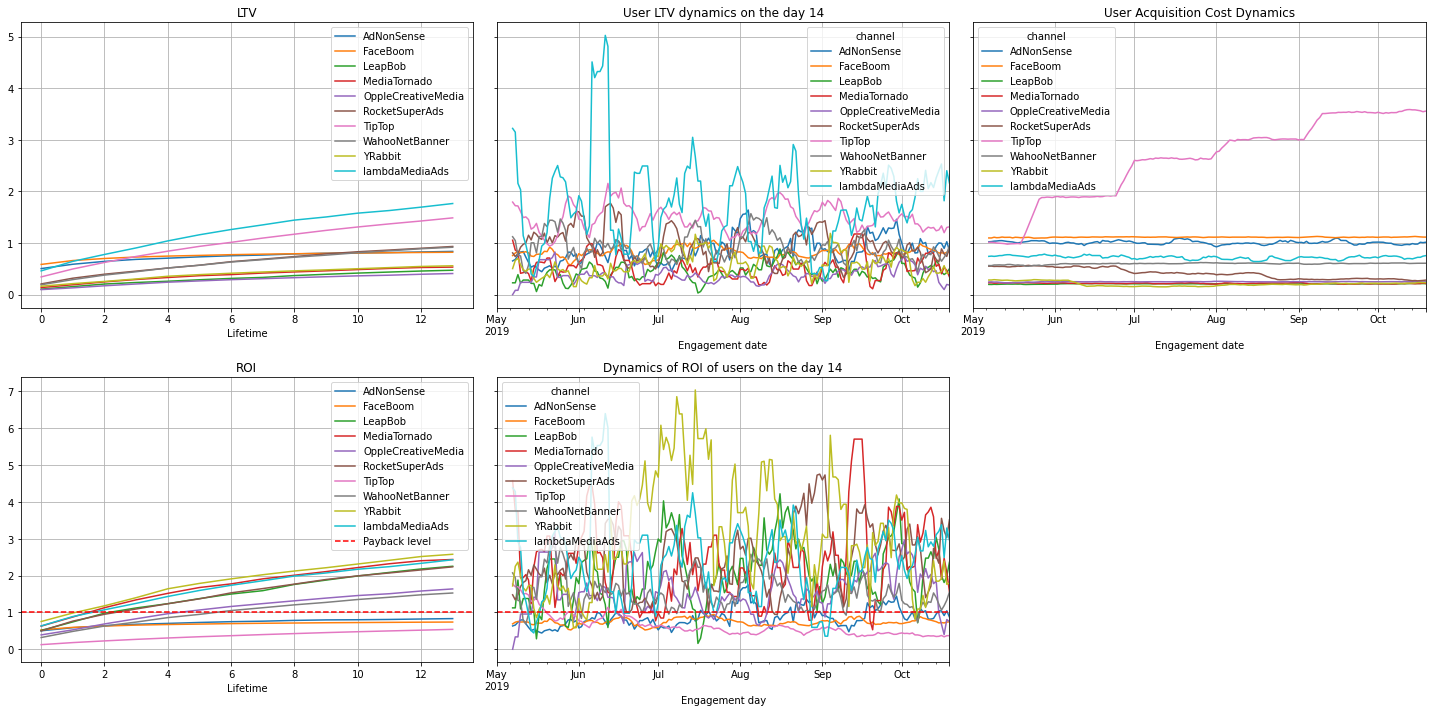

In [93]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

#### Conclusions
We see that only three firms do not return on investment - these are FaceBoom, TipTop (although this firm is in the lead in terms of LTV) and AdNonSense. The first two account for more than 80% of the total budget.

We also see that the cost of attracting users grows only for TipTop and very significantly, almost 3.5 times. The rest of the agencies are stable, while the price of RocketSuperAds is even falling. You need to check with the marketing department how TipTop justifies such a strong price increase when taking into account a constant LTV, not to mention ROI.

We also see an interesting fact that lambdaMediaAds has a clear lead in LTV (1.8) with peaks of 3-5 rubles on the 14th day. 

### Analysis of conversion and retention by region

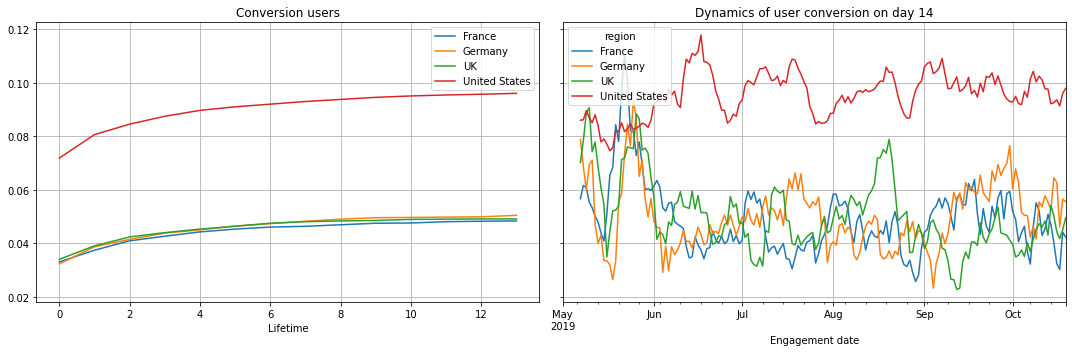

In [94]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['region']
)

plot_conversion(conversion, conversion_history, horizon)

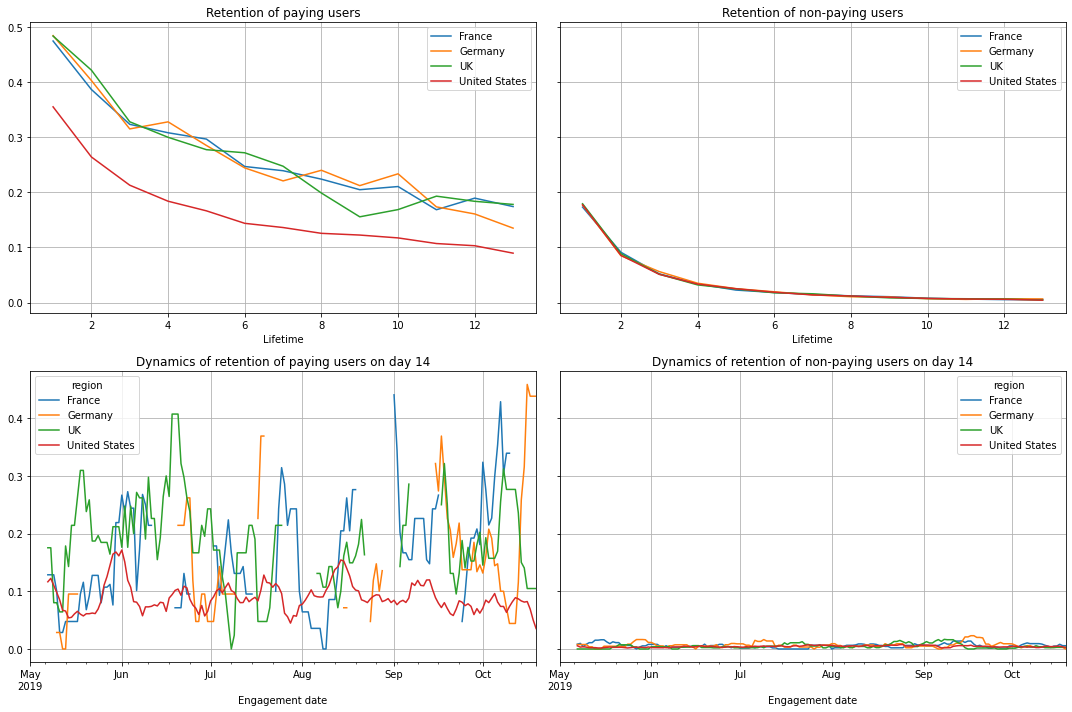

In [95]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon, 
    dimensions = ['region'])
plot_retention(retention, retention_history, horizon, window=7)

#### Conclusions
We observe that the conversion is stable over the entire period, but the conversion in the US is almost twice as high as in France, Germany and England, but the retention of paying users in three countries is twice as high compared to the US.
The retention of non-paying users for the entire period tends to zero.

### Conversion and retention analysis by device

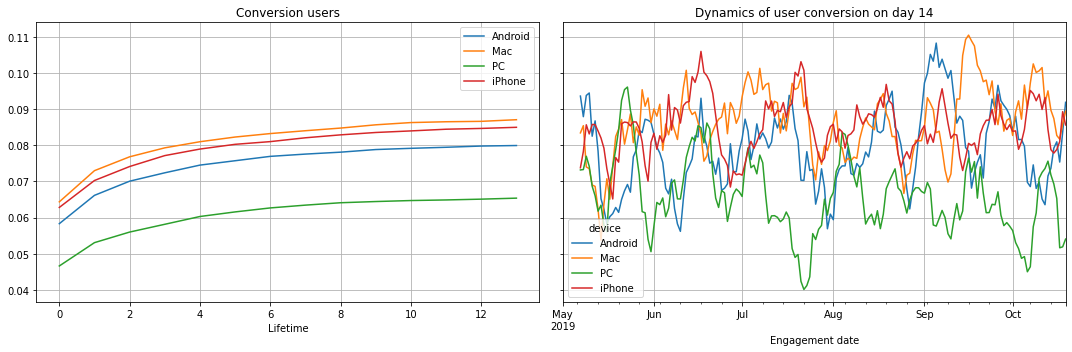

In [96]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['device']
)

plot_conversion(conversion, conversion_history, horizon)

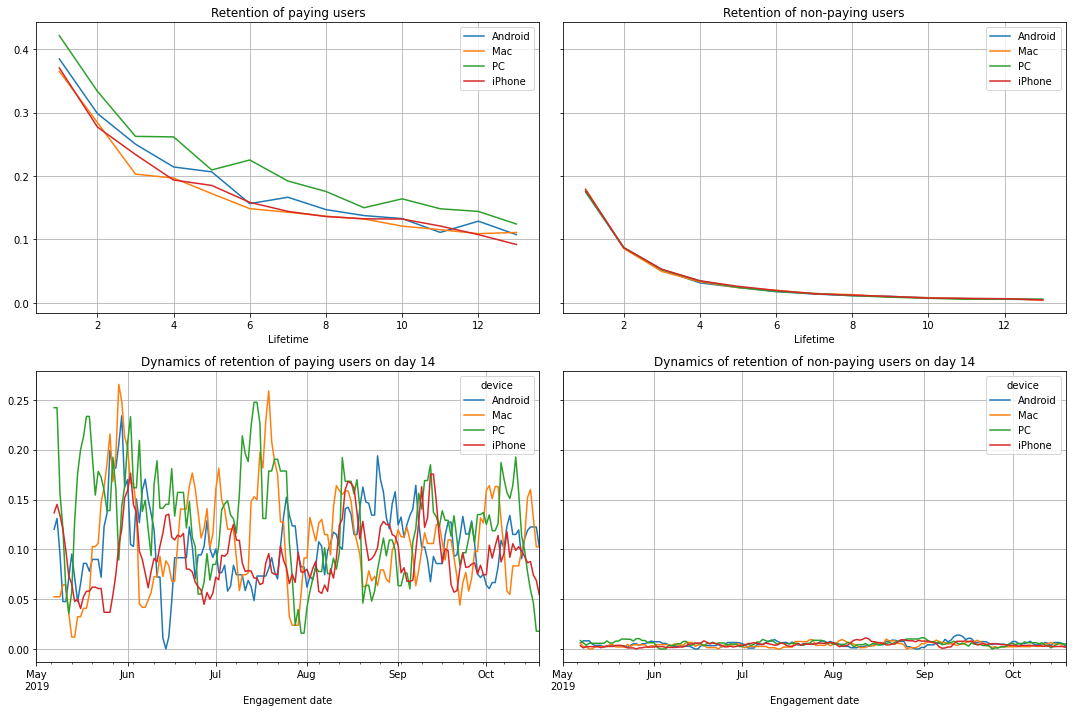

In [97]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon, 
    dimensions = ['device'])
plot_retention(retention, retention_history, horizon, window=7)

#### conclusions
We can see that at the device level, conversion and retention are not much different. Only the RS conversion is 30% lower compared to the other three devices. Retention of non-paying users also tends to zero over the entire period

### Analysis of conversion and retention by channel

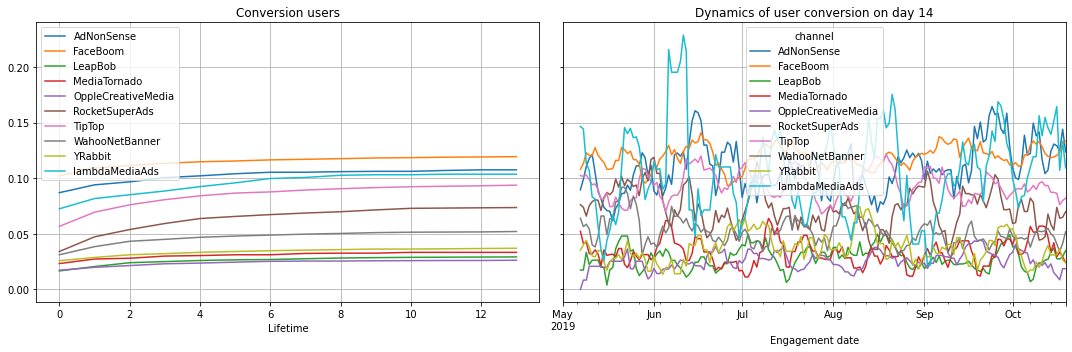

In [98]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['channel']
)

plot_conversion(conversion, conversion_history, horizon)

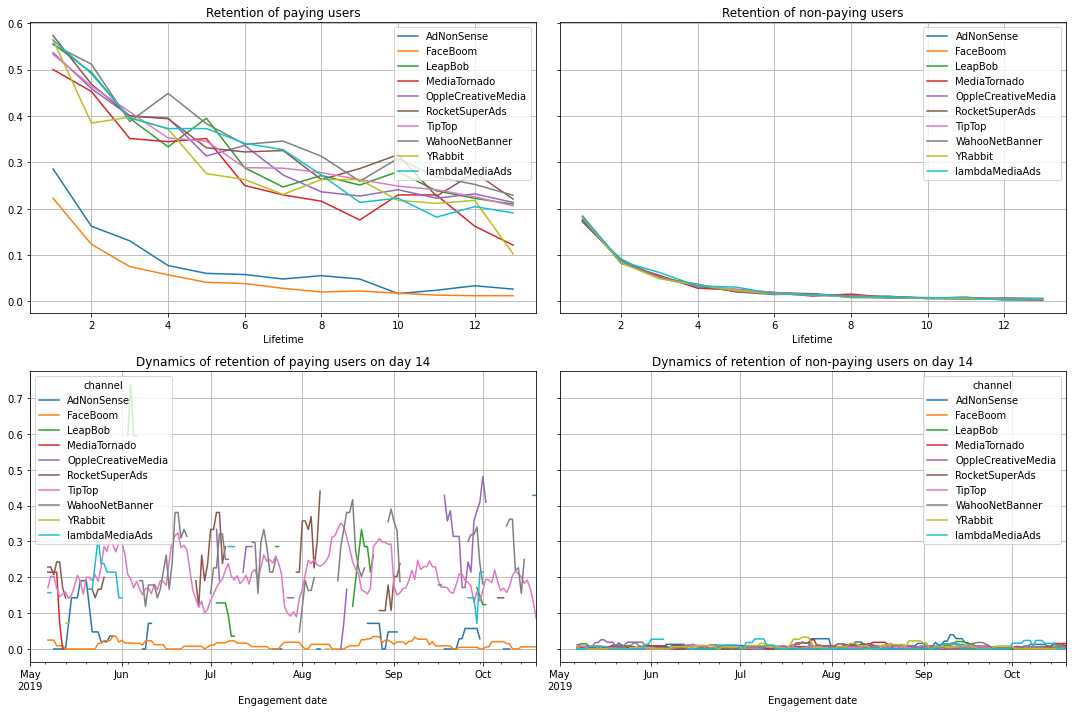

In [99]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon, 
    dimensions = ['channel'])
plot_retention(retention, retention_history, horizon, window=7)

#### Conclusions
We see that Faceboom, TipTop and AdNonsense are in the lead in terms of conversions, as well as lambdaMediaArts. But interestingly, AdNonSense and Faceboom both show very suspicious paying customer retention curves that match very well with non-paying customer retention curves. No other anomalies have been identified.

In [109]:
#Evaluation of countries from which agencies attract clients
profiles.groupby(['channel', 'region'])['region'].count()

channel             region       
AdNonSense          France            1366
                    Germany           1219
                    UK                1295
FaceBoom            United States    29144
LeapBob             France            2988
                    Germany           2519
                    UK                3046
MediaTornado        United States     4364
OppleCreativeMedia  France            2991
                    Germany           2562
                    UK                3052
RocketSuperAds      United States     4448
TipTop              United States    19561
WahooNetBanner      France            2971
                    Germany           2579
                    UK                3003
YRabbit             United States     4312
lambdaMediaAds      France             742
                    Germany            649
                    UK                 758
Name: region, dtype: int64

## Conclusions

For the period from 01-05-2019 to 27-10-2019, 150,008 new users were attracted and 8881 (6%) of them became paid users. The total advertising budget for the same period amounted to more than 100,000 rubles, and more than 80% of them were spent on only two agencies (out of ten) FaceBoom and TipTop.

We see that the total investment does not pay off. This is due to the fact that most of it was invested in Faceboom and TipTop, although users from these channels had the highest LTV, spending on them never paid off due to their strong overvaluation, except for May.

Recommendations for the marketing department:
 * First of all, find out what caused such an unreasonable bias towards investing in FaceBoom and TipTop (more than 80% of the total budget)
 * Pay attention to the other three countries (Great Britain, France and Germany), users from there almost always pay off and make a profit.
 * Prefer lambdaMediaAds, MediaTornado and YRabbit agencies for now
 * Find out why customers from only four countries come. Try to start test expanding the geography of the market, since both in Europe and in North America the service can be profitable.